# Analysis of N-gram Regression Model Results

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from scipy.stats import spearmanr
import sys
import os

# Add src to the Python path to import the config file
sys.path.append('src')
from config import (
    DATA_FILE, TARGET_PROPERTIES, FOLD_COLUMN, FOLDS, VH_SEQUENCE_COL,
    VL_SEQUENCE_COL, HC_SUBTYPE_COL, ARTEFACTS_DIR, LOG_TRANSFORM_TARGETS
)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

### 1. Import Libraries and Configuration

First, we import all the necessary libraries for data manipulation, loading artefacts, and plotting. We also import the project's configuration file to access global variables like file paths and column names.

### 1.1. Select Model Type
Specify which model's results you want to analyze: 'ridge' or 'gbr'.

In [2]:
# Set this to 'ridge' or 'gbr' to analyze the corresponding model's results
MODEL_TYPE_TO_ANALYZE = 'ridge'

## 1.2. Hyperparameter Search (Optional)

This section demonstrates how to use the new hyperparameter search feature. The search optimizes:
- **alpha**: Ridge regression regularization strength
- **ngram_max**: Maximum n-gram size for character-level TF-IDF
- **vocab_size**: Total vocabulary size (split between VH and VL sequences)

The search uses Bayesian optimization (scikit-optimize) to maximize the average Spearman correlation across all targets and CV folds.

**Note**: A full search with `--n-iter 50` can take hours. For demonstration purposes, use a smaller value like `--n-iter 5`.

### 1.2. Per-target Hyperparameter Tuning (alpha, ngram_max, vocab_size)

You can now tune hyperparameters separately for each target. This will write per-target entries into `artefacts/best_params.json` and separate CSVs per target.

- Run global (average across targets): `!python -m src.models.hyperparameter_search --n-iter 30 --target avg`
- Run for a single target (example: `Titer`): `!python -m src.models.hyperparameter_search --n-iter 30 --target Titer`
- Run for all targets: `!python -m src.models.hyperparameter_search --n-iter 30 --target all`

After per-target searches, rebuild features per target and retrain models.

In [3]:
# Run hyperparameter search (uncomment to run - can be slow!)
# Adjust --n-iter based on your compute budget (5-10 for demo, 50+ for production)

# !python -m src.models.hyperparameter_search --n-iter 5

### 1.2.1. Load and Visualize Hyperparameter Search Results

If you've run the hyperparameter search (or it was run previously), you can load the results and visualize the optimization trajectory.

In [4]:
import json
from pathlib import Path

# Load best parameters if available
best_params_path = Path('artefacts/best_params.json')

if best_params_path.exists():
    with open(best_params_path, 'r') as f:
        best_params = json.load(f)
    
    print("=" * 60)
    print("BEST HYPERPARAMETERS FOUND:")
    print("=" * 60)
        
    # Show per-target parameters if they exist
    if 'per_target' in best_params:
        print("\n--- PER-TARGET HYPERPARAMETERS ---")
        for target, params in best_params['per_target'].items():
            print(f"\n{target}:")
            print(f"  Alpha:           {params['alpha']:.3e}")
            print(f"  N-gram max:      {params['ngram_max']}")
            print(f"  Vocabulary size: {params['vocab_size']}")
            print(f"  Best Spearman:   {-params['best_objective']:.6f}")
    
    print("=" * 60)
else:
    print("No hyperparameter search results found.")
    print("Run the search first or use default parameters from config.py")


BEST HYPERPARAMETERS FOUND:

--- PER-TARGET HYPERPARAMETERS ---

Titer:
  Alpha:           4.563e-01
  N-gram max:      3
  Vocabulary size: 27288
  Best Spearman:   0.423096

HIC:
  Alpha:           9.063e-04
  N-gram max:      1
  Vocabulary size: 1000
  Best Spearman:   0.473563

PR_CHO:
  Alpha:           1.726e-02
  N-gram max:      1
  Vocabulary size: 26623
  Best Spearman:   0.539217

Tm2:
  Alpha:           1.000e+01
  N-gram max:      64
  Vocabulary size: 10193
  Best Spearman:   0.408855

AC-SINS_pH7.4:
  Alpha:           1.003e-01
  N-gram max:      1
  Vocabulary size: 1000
  Best Spearman:   0.459266



Per-Target Hyperparameter Search Results


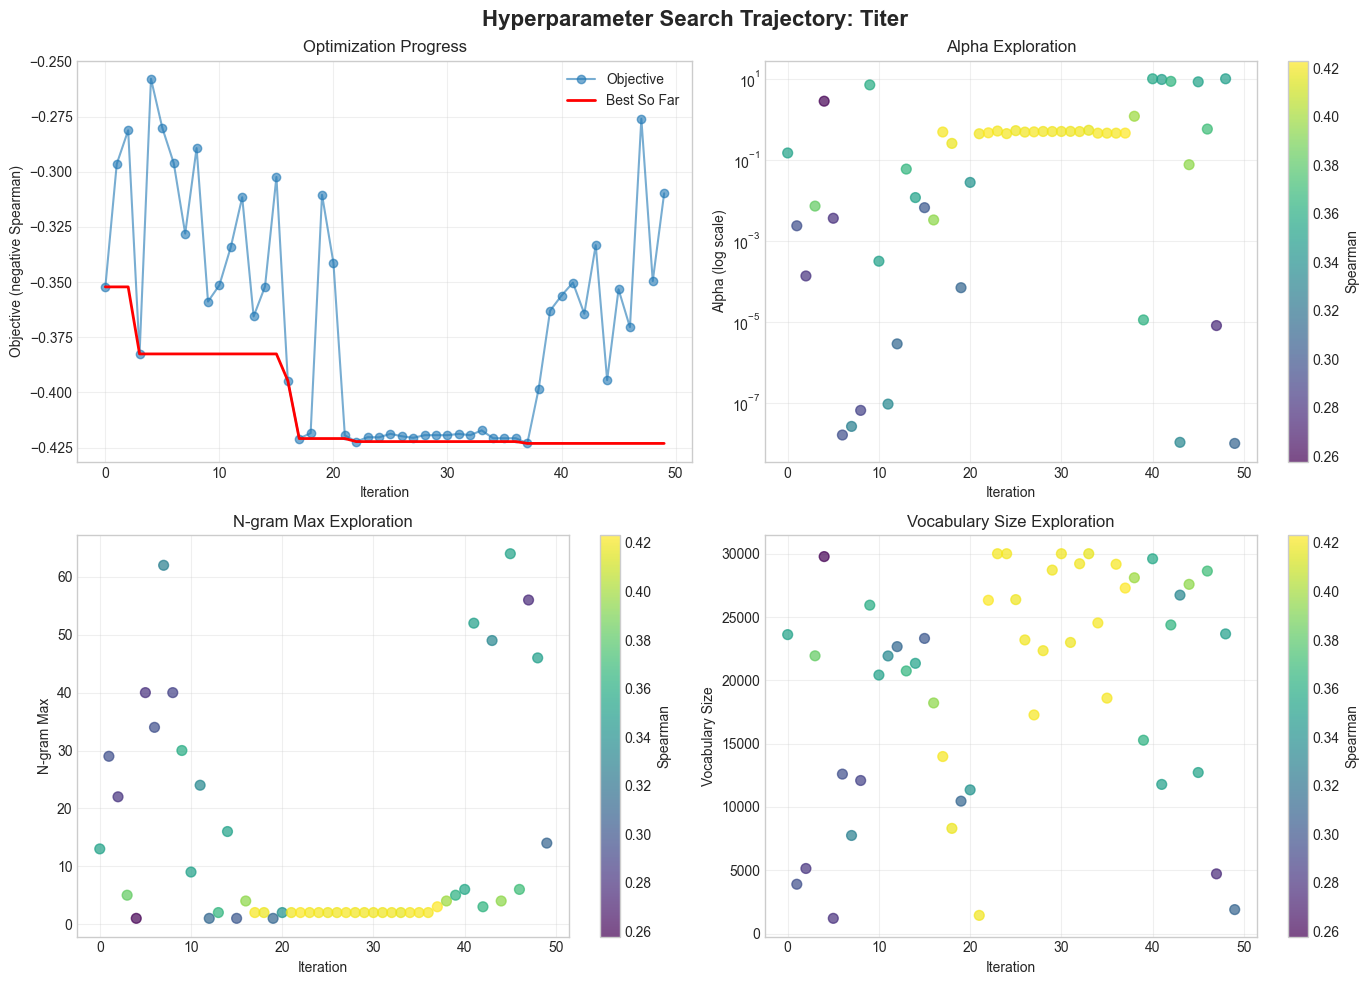


Titer:
  Total iterations: 50
  Best iteration: 37
  Best alpha: 4.563e-01
  Best ngram_max: 3.0
  Best vocab_size: 27288.0
  Best Spearman: 0.423096


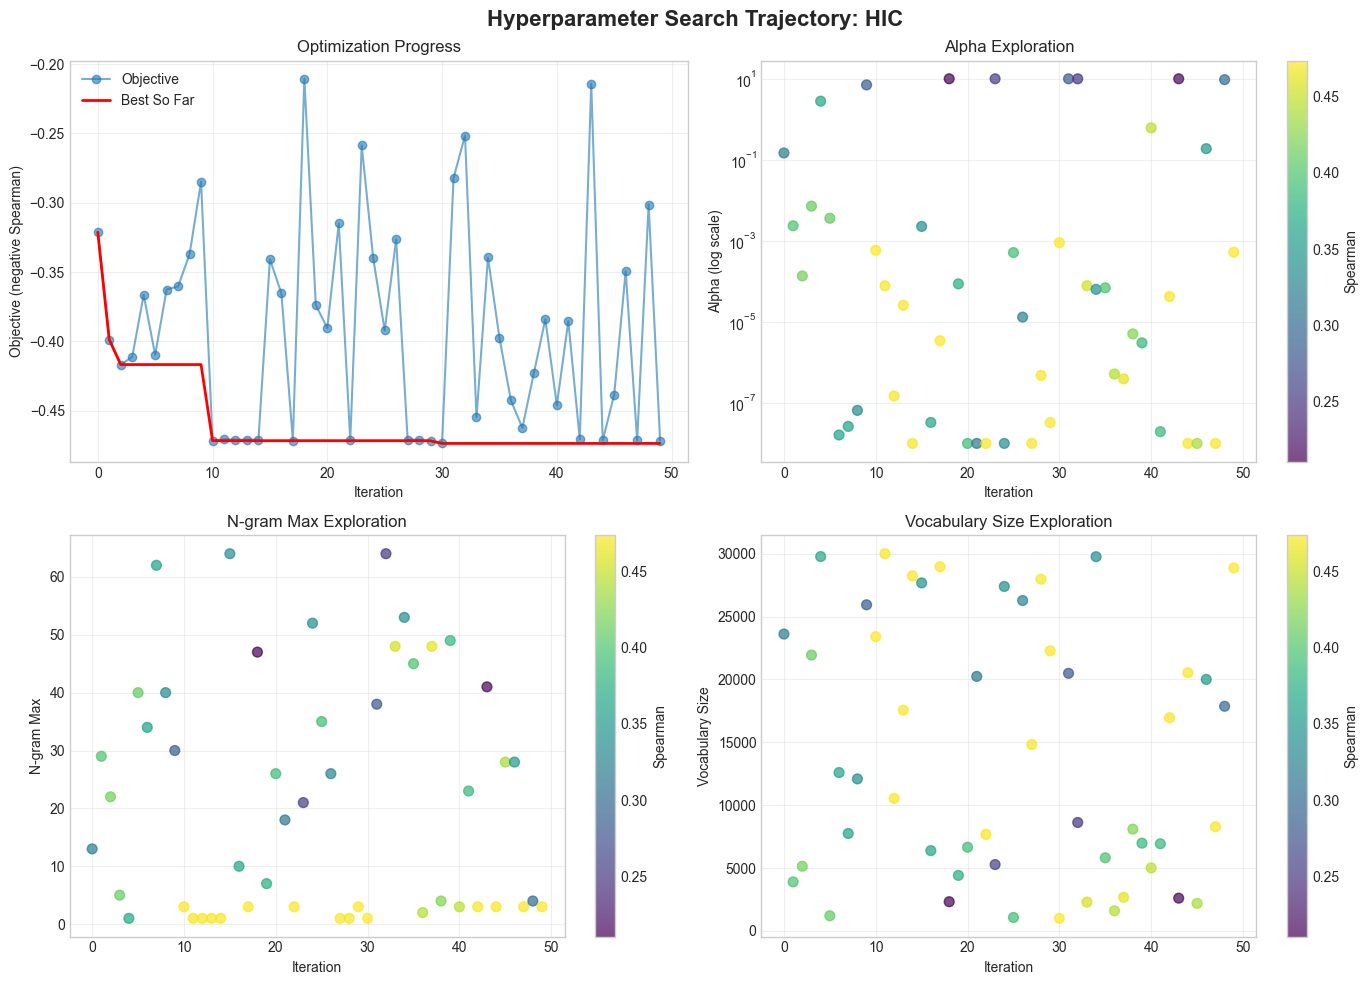


HIC:
  Total iterations: 50
  Best iteration: 30
  Best alpha: 9.063e-04
  Best ngram_max: 1.0
  Best vocab_size: 1000.0
  Best Spearman: 0.473563


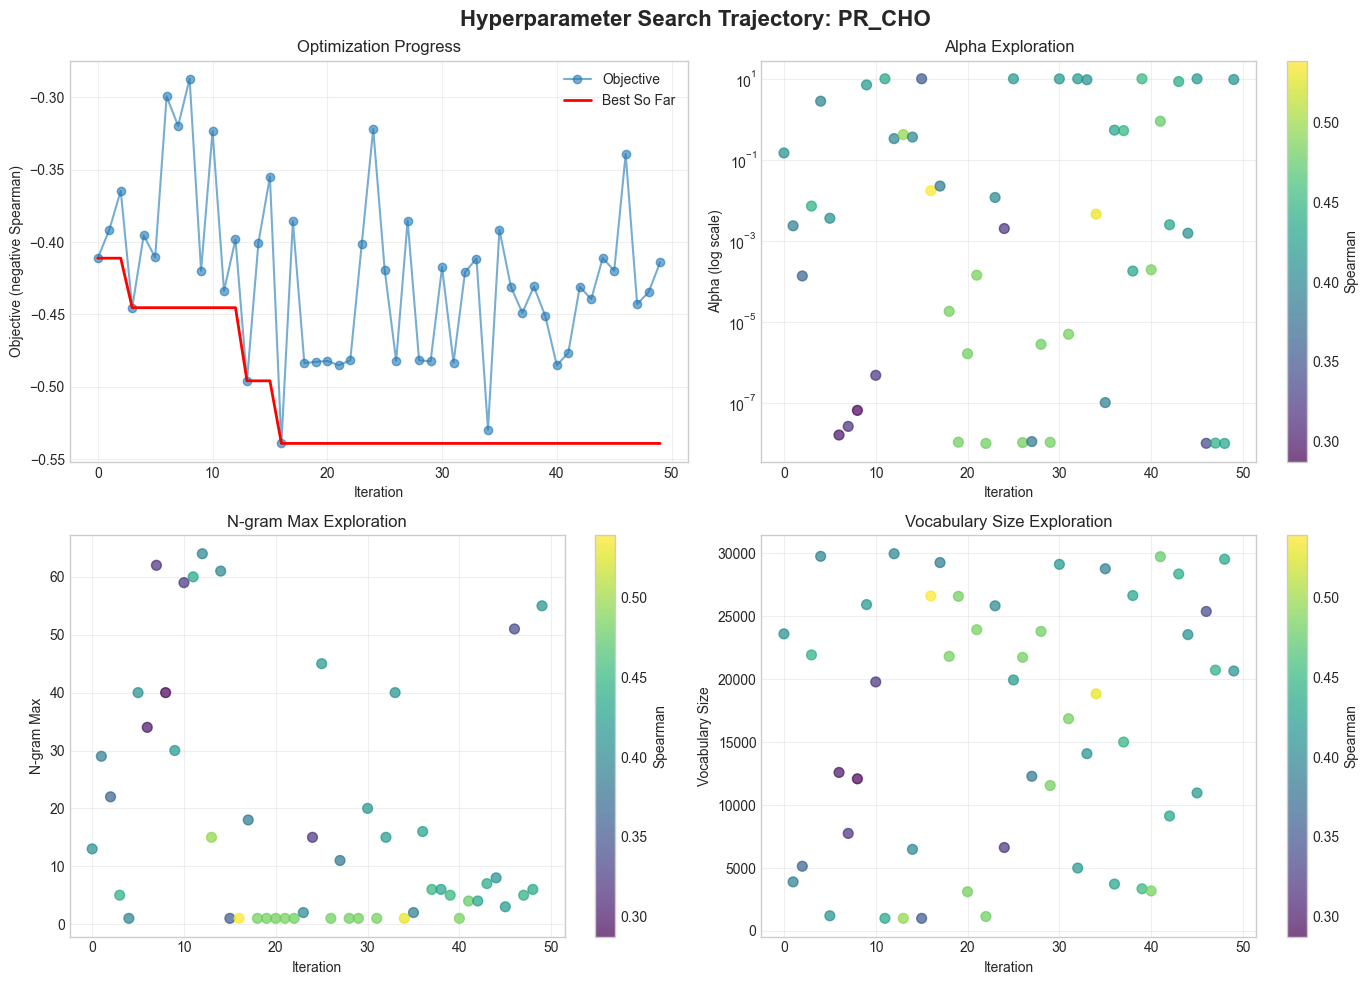


PR_CHO:
  Total iterations: 50
  Best iteration: 16
  Best alpha: 1.726e-02
  Best ngram_max: 1.0
  Best vocab_size: 26623.0
  Best Spearman: 0.539217


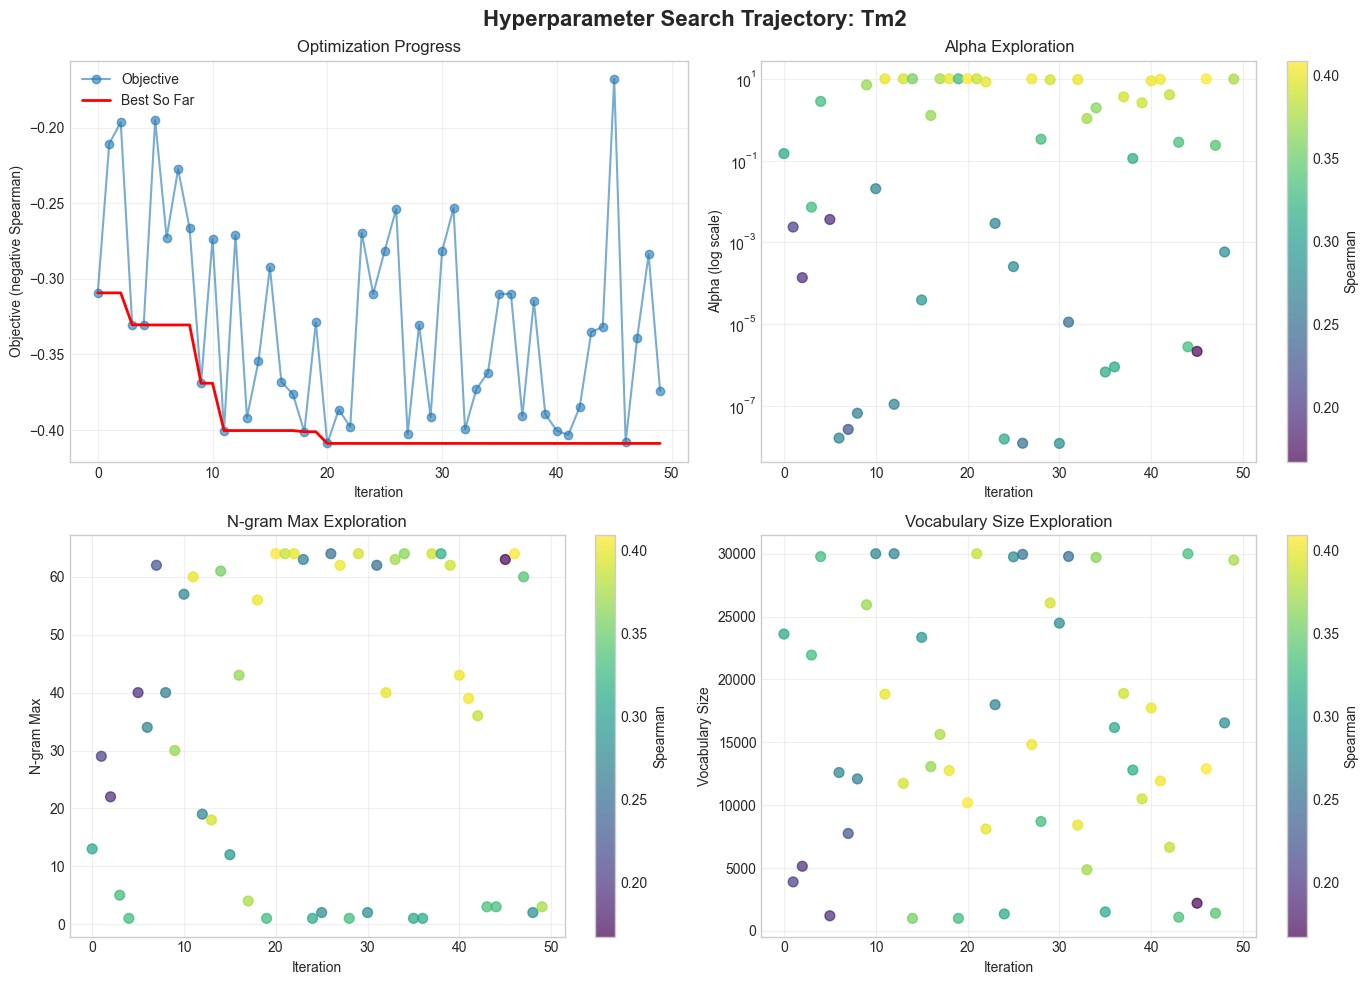


Tm2:
  Total iterations: 50
  Best iteration: 20
  Best alpha: 1.000e+01
  Best ngram_max: 64.0
  Best vocab_size: 10193.0
  Best Spearman: 0.408855


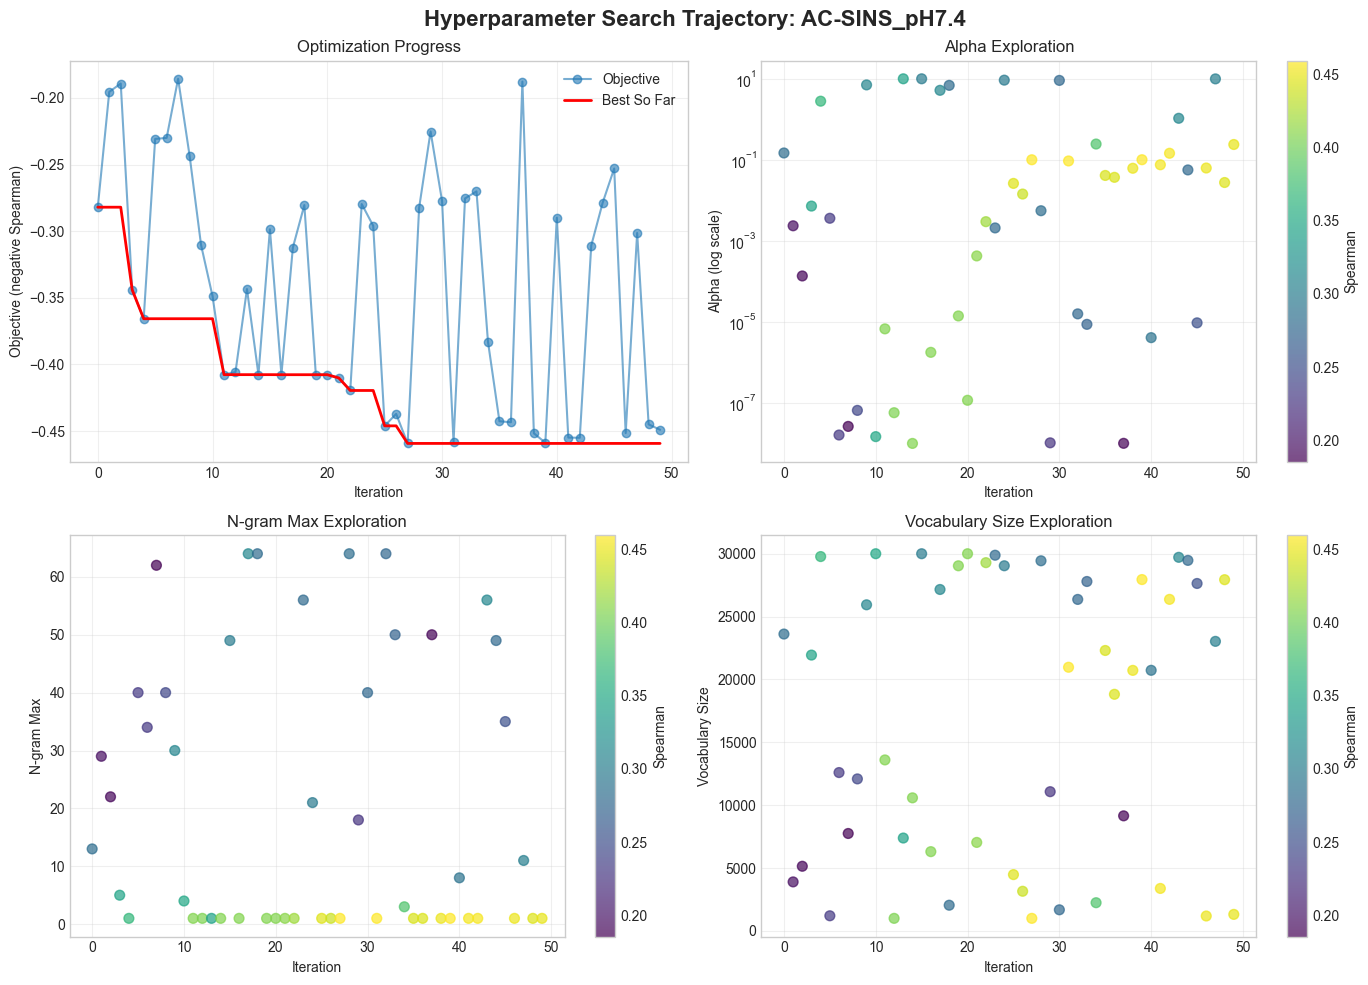


AC-SINS_pH7.4:
  Total iterations: 50
  Best iteration: 27
  Best alpha: 1.003e-01
  Best ngram_max: 1.0
  Best vocab_size: 1000.0
  Best Spearman: 0.459266


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Visualize the search trajectory

# Now check for per-target results
print("\n" + "="*60)
print("Per-Target Hyperparameter Search Results")
print("="*60)

from config import TARGET_PROPERTIES

for target in TARGET_PROPERTIES:
    target_results_path = Path(f'hyperparameter_search_results_{target}.csv')
    
    if target_results_path.exists():
        target_df = pd.read_csv(target_results_path)
        
        # Create a figure with subplots for this target
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f'Hyperparameter Search Trajectory: {target}', fontsize=16, fontweight='bold')
        
        # Plot 1: Objective value over iterations
        ax1 = axes[0, 0]
        ax1.plot(target_df.index, target_df['objective_value'], 'o-', alpha=0.6, label='Objective')
        ax1.plot(target_df.index, target_df['objective_value'].cummin(), 'r-', linewidth=2, label='Best So Far')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Objective (negative Spearman)')
        ax1.set_title('Optimization Progress')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Alpha exploration
        ax2 = axes[0, 1]
        scatter = ax2.scatter(target_df.index, target_df['alpha'], 
                             c=-target_df['objective_value'], cmap='viridis', alpha=0.7, s=50)
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Alpha (log scale)')
        ax2.set_yscale('log')
        ax2.set_title('Alpha Exploration')
        ax2.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax2, label='Spearman')
        
        # Plot 3: N-gram max exploration
        ax3 = axes[1, 0]
        scatter = ax3.scatter(target_df.index, target_df['ngram_max'], 
                             c=-target_df['objective_value'], cmap='viridis', alpha=0.7, s=50)
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('N-gram Max')
        ax3.set_title('N-gram Max Exploration')
        ax3.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax3, label='Spearman')
        
        # Plot 4: Vocabulary size exploration
        ax4 = axes[1, 1]
        scatter = ax4.scatter(target_df.index, target_df['vocab_size'], 
                             c=-target_df['objective_value'], cmap='viridis', alpha=0.7, s=50)
        ax4.set_xlabel('Iteration')
        ax4.set_ylabel('Vocabulary Size')
        ax4.set_title('Vocabulary Size Exploration')
        ax4.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax4, label='Spearman')
        
        plt.tight_layout()
        plt.show()
        
        best_idx = target_df['objective_value'].idxmin()
        best_row = target_df.loc[best_idx]
        print(f"\n{target}:")
        print(f"  Total iterations: {len(target_df)}")
        print(f"  Best iteration: {best_idx}")
        print(f"  Best alpha: {best_row['alpha']:.3e}")
        print(f"  Best ngram_max: {best_row['ngram_max']}")
        print(f"  Best vocab_size: {best_row['vocab_size']}")
        print(f"  Best Spearman: {-best_row['objective_value']:.6f}")
    else:
        print(f"\n{target}: No search results found")


### 1.2.2. Rebuild Features with Tuned Hyperparameters

After finding the best hyperparameters, we need to rebuild the feature transformers (vectorizers) with the optimized `ngram_max` and `vocab_size`. This will update the saved transformers in `artefacts/`.

In [6]:
# Rebuild features with tuned hyperparameters (uncomment to run)
# This will overwrite the existing vectorizers in artefacts/

# !python -m src.features.build_features --use-best

### 1.2.2a. Build Per-target Features

After running per-target search, rebuild vectorizers per target using tuned `ngram_max` and `vocab_size`:

- Build all targets: `!python -m src.features.build_features --use-best --target all`
- Build one target: `!python -m src.features.build_features --use-best --target Titer`

This will save artefacts like `vectorizer_vh_Titer.joblib`, `vectorizer_vl_Titer.joblib`, and `encoder_ohe_Titer.joblib` in the `artefacts/` folder.

### 1.2.3. Retrain Models with Optimized Features

After rebuilding the features, retrain the Ridge models to use the tuned `alpha` parameter along with the optimized feature extraction settings. The training script will automatically use the tuned alpha from `best_params.json`.

In [7]:
# Retrain Ridge models with tuned hyperparameters (uncomment to run)
# By default, train_model.py will use the alpha from best_params.json

# !python -m src.models.train_model --model-type ridge

### 1.2.3a. Retrain with Per-target Settings

Training will automatically:
- Use `alpha` from `best_params.json` per target if present (fallback to global alpha), and
- Load per-target vectorizers when available, otherwise falling back to global ones.

- Retrain ridge: `!python -m src.models.train_model --model-type ridge`
- Retrain GBR: `!python -m src.models.train_model --model-type gbr`

---

**Pipeline Summary:**

The workflow now supports both global (averaged across targets) and per-target hyperparameter tuning:

**Option 1: Global Hyperparameter Tuning (Original)**
1. Run global search: `python -m src.models.hyperparameter_search --n-iter 30 --target avg`
2. Rebuild features: `python -m src.features.build_features --use-best`
3. Retrain models: `python -m src.models.train_model --model-type ridge`

**Option 2: Per-Target Hyperparameter Tuning (Recommended)**
1. Run per-target search for all targets: `python -m src.models.hyperparameter_search --n-iter 30 --target all`
   - Or run individually: `--target Titer`, `--target HIC`, etc.
2. Rebuild features per target: `python -m src.features.build_features --use-best --target all`
3. Retrain models (automatically uses per-target params): `python -m src.models.train_model --model-type ridge`

**Benefits of Per-Target Tuning:**
- Each target gets optimized hyperparameters specific to its characteristics
- Typically leads to better performance than one-size-fits-all global parameters
- Results show in the comparison visualizations above

Continue with the analysis below to visualize predictions from your trained models!

---


### 2. Load Data and Transformers

Next, we load the main dataset and the pre-fitted transformers (vectorizers and one-hot encoder) that were created during the feature engineering phase. 

**Note**: With per-target hyperparameter tuning, the system now supports:
- **Global transformers**: Trained with parameters averaged across all targets (fallback)
- **Per-target transformers**: Trained with target-specific hyperparameters (e.g., `vectorizer_vh_Titer.joblib`)

The prediction function will automatically try to load per-target transformers first, falling back to global transformers if they don't exist.


In [ ]:
try:
    df = pd.read_csv(DATA_FILE)
    
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the data file exists.")


Data loaded successfully.


In [9]:
# Check which targets have per-target transformers available
print("\n" + "="*60)
print("TRANSFORMER AVAILABILITY CHECK")
print("="*60)

for target in TARGET_PROPERTIES:
    vh_target = ARTEFACTS_DIR / f'vectorizer_vh_{target}.joblib'
    vl_target = ARTEFACTS_DIR / f'vectorizer_vl_{target}.joblib'
    ohe_target = ARTEFACTS_DIR / f'encoder_ohe_{target}.joblib'
    
    has_per_target = vh_target.exists() and vl_target.exists() and ohe_target.exists()
    
    if has_per_target:
        print(f"✓ {target}: Per-target transformers available")
    else:
        print(f"○ {target}: Will use global transformers (fallback)")

print("="*60)



TRANSFORMER AVAILABILITY CHECK
✓ Titer: Per-target transformers available
✓ HIC: Per-target transformers available
✓ PR_CHO: Per-target transformers available
✓ Tm2: Per-target transformers available
✓ AC-SINS_pH7.4: Per-target transformers available


### 3. Generate Predictions with Uncertainty

This is the core function for our analysis. For a given target property, it performs the following steps:
1. Loads the corresponding trained model ensembles for the specified target and model type.
2. **Attempts to load per-target transformers** (vectorizers and encoder). If not found, falls back to global transformers.
3. Iterates through each of the 5 cross-validation folds.
4. For each fold, it identifies the test set, transforms its features, and generates predictions using the appropriate ensemble of bootstrap models.
5. It calculates the mean and standard deviation of the predictions from the ensemble for each data point in the test set.
6. It collects and returns the true values, predicted means, and predicted standard deviations for all data points across all folds.

**Per-Target Support**: This function now automatically handles both per-target and global transformer configurations, making it compatible with the new per-target hyperparameter tuning workflow.


In [10]:
def get_predictions_with_uncertainty(df, target, model_type):
    """
    Generates predictions for a target property across all 5 CV folds.
    Now supports per-target transformers and models.
    
    Args:
        df (pd.DataFrame): The full dataset.
        target (str): The name of the target property.
        model_type (str): The type of model to use ('ridge' or 'gbr').
        
    Returns:
        tuple: A tuple containing (y_true_all, y_pred_mean_all, y_pred_std_all).
    """
    # Try to load per-target models first, fall back to non-suffixed names
    model_filename = ARTEFACTS_DIR / f'models_{target}_{model_type}.joblib'
    if not model_filename.exists():
        model_filename = ARTEFACTS_DIR / f'models_{target}.joblib'
    
    try:
        all_fold_ensembles = joblib.load(model_filename)
        print(f"Loaded models from {model_filename}")
    except FileNotFoundError:
        print(f"Models for {target} ({model_type}) not found. Please run the training script first.")
        return None, None, None
    
    # Try to load per-target transformers, fall back to global
    try:
        vectorizer_vh = joblib.load(ARTEFACTS_DIR / f'vectorizer_vh_{target}.joblib')
        vectorizer_vl = joblib.load(ARTEFACTS_DIR / f'vectorizer_vl_{target}.joblib')
        encoder_ohe = joblib.load(ARTEFACTS_DIR / f'encoder_ohe_{target}.joblib')
        print(f"Using per-target transformers for {target}")
    except FileNotFoundError:
        # Fall back to global transformers
        if vectorizer_vh_global is None or vectorizer_vl_global is None or encoder_ohe_global is None:
            print(f"Error: Neither per-target nor global transformers found for {target}")
            return None, None, None
        vectorizer_vh = vectorizer_vh_global
        vectorizer_vl = vectorizer_vl_global
        encoder_ohe = encoder_ohe_global
        print(f"Using global transformers for {target}")

    df_target = df.dropna(subset=[target]).copy()
    
    y_true_all = []
    y_pred_mean_all = []
    y_pred_std_all = []

    for fold_i in FOLDS:
        test_mask = (df_target[FOLD_COLUMN] == fold_i)
        df_test = df_target[test_mask]
        
        if df_test.empty:
            continue

        y_true = df_test[target].values
        
        # Transform features
        X_test_vh = vectorizer_vh.transform(df_test[VH_SEQUENCE_COL])
        X_test_vl = vectorizer_vl.transform(df_test[VL_SEQUENCE_COL])
        X_test_ohe = encoder_ohe.transform(df_test[[HC_SUBTYPE_COL]])
        X_test = hstack([X_test_vh, X_test_vl, X_test_ohe], format='csr')

        # Get the ensemble for this fold
        ensemble_models = all_fold_ensembles[fold_i]
        
        # Generate predictions from each model in the ensemble
        fold_predictions = [model.predict(X_test) for model in ensemble_models]
        
        # If target was log-transformed, convert predictions back to original scale
        if target in LOG_TRANSFORM_TARGETS:
            fold_predictions = np.expm1(fold_predictions)

        # Calculate mean and std dev across the ensemble predictions
        y_pred_mean = np.mean(fold_predictions, axis=0)
        y_pred_std = np.std(fold_predictions, axis=0)
        
        y_true_all.extend(y_true)
        y_pred_mean_all.extend(y_pred_mean)
        y_pred_std_all.extend(y_pred_std)
        
    return np.array(y_true_all), np.array(y_pred_mean_all), np.array(y_pred_std_all)


### 4. Process All Targets and Store Results

Now, we loop through all the target properties defined in our configuration. For each one, we call the function above to get the true values and predictions, and we store these results in a dictionary for later use.

In [11]:
results = {}
for target in TARGET_PROPERTIES:
    print(f"Processing {target} for model type {MODEL_TYPE_TO_ANALYZE}...")
    y_true, y_pred_mean, y_pred_std = get_predictions_with_uncertainty(df, target, MODEL_TYPE_TO_ANALYZE)
    if y_true is not None:
        results[target] = {
            'true': y_true,
            'pred_mean': y_pred_mean,
            'pred_std': y_pred_std
        }
print("All targets processed.")

Processing Titer for model type ridge...
Loaded models from /Users/kyunghyuncho/Repos/strawman-ab/artefacts/models_Titer_ridge.joblib
Using per-target transformers for Titer
Processing HIC for model type ridge...
Loaded models from /Users/kyunghyuncho/Repos/strawman-ab/artefacts/models_HIC_ridge.joblib
Using per-target transformers for HIC
Processing PR_CHO for model type ridge...
Loaded models from /Users/kyunghyuncho/Repos/strawman-ab/artefacts/models_PR_CHO_ridge.joblib
Using per-target transformers for PR_CHO
Processing Tm2 for model type ridge...
Loaded models from /Users/kyunghyuncho/Repos/strawman-ab/artefacts/models_Tm2_ridge.joblib
Using per-target transformers for Tm2
Processing AC-SINS_pH7.4 for model type ridge...
Loaded models from /Users/kyunghyuncho/Repos/strawman-ab/artefacts/models_AC-SINS_pH7.4_ridge.joblib
Using per-target transformers for AC-SINS_pH7.4
All targets processed.


### 5. Visualize Results: True vs. Predicted with Uncertainty

Finally, we create the scatter plots. For each target property, we plot the true values against the mean of the predicted values. The vertical error bars on each point represent the standard deviation of the predictions from the bootstrap ensemble, giving us a visual sense of the model's confidence for each prediction. We also calculate and display the Spearman rank correlation, which is our primary evaluation metric.

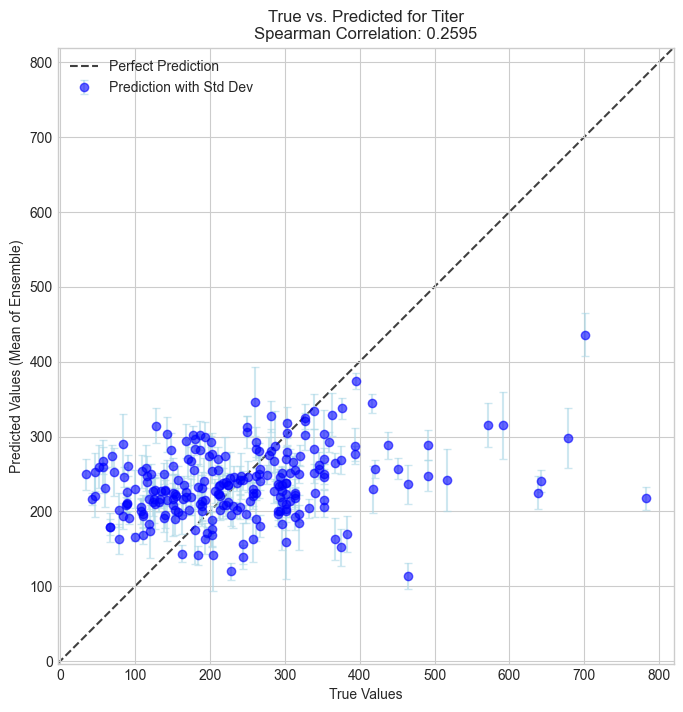

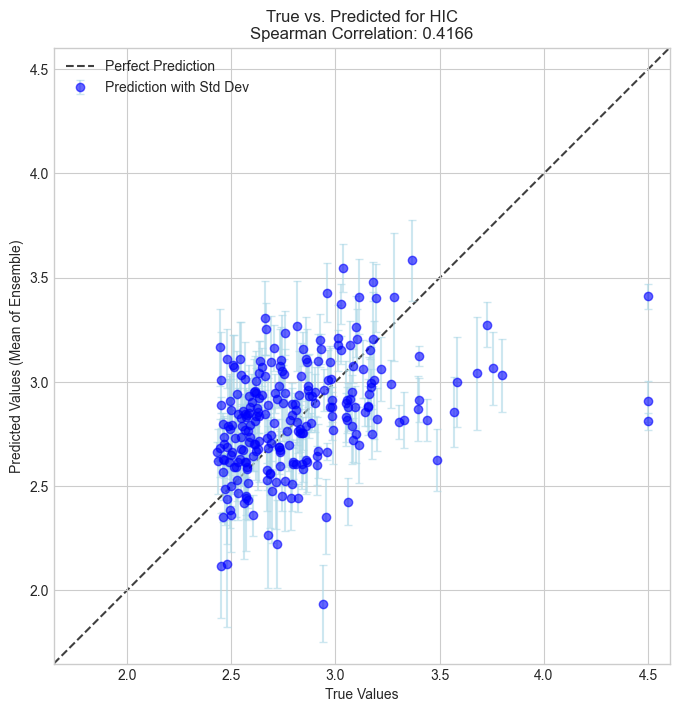

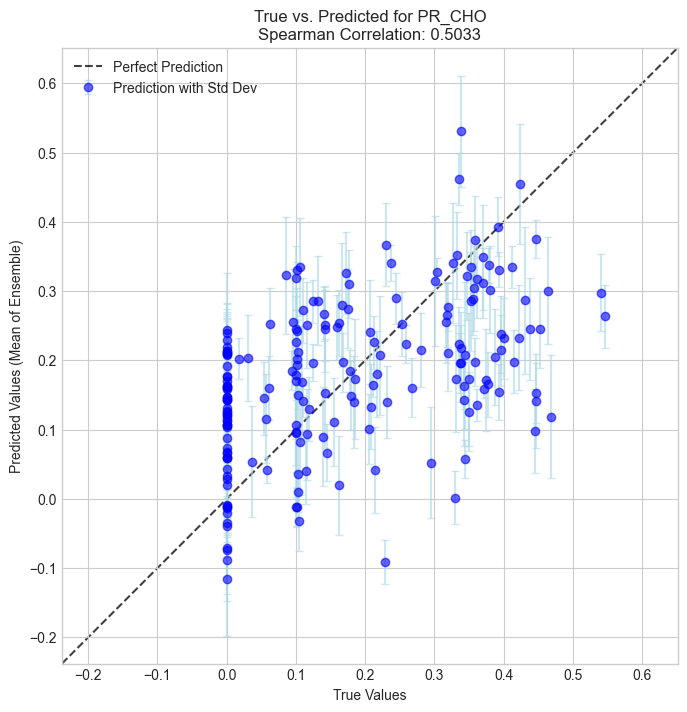

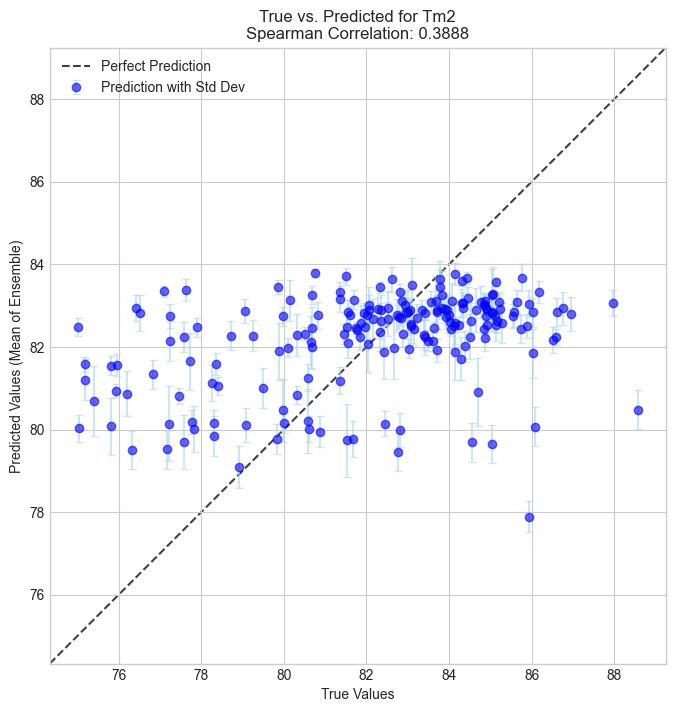

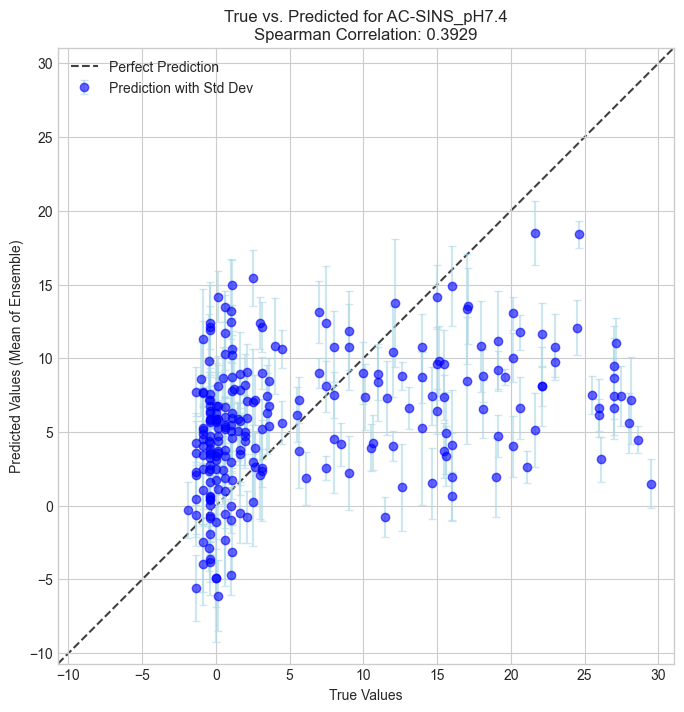

In [12]:
for target, data in results.items():
    y_true = data['true']
    y_pred_mean = data['pred_mean']
    y_pred_std = data['pred_std']
    
    # Calculate Spearman correlation
    corr, _ = spearmanr(y_true, y_pred_mean)
    
    plt.figure(figsize=(8, 8))
    
    # Create scatter plot with error bars
    plt.errorbar(y_true, y_pred_mean, yerr=y_pred_std, fmt='o', color='blue', ecolor='lightblue', capsize=3, alpha=0.6, label='Prediction with Std Dev')
    
    # Plot the 'perfect prediction' line
    lims = [
        np.min([plt.xlim(), plt.ylim()]),
        np.max([plt.xlim(), plt.ylim()]),
    ]
    plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='Perfect Prediction')
    plt.xlim(lims)
    plt.ylim(lims)
    
    plt.title(f'True vs. Predicted for {target}\nSpearman Correlation: {corr:.4f}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values (Mean of Ensemble)')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()